In [1]:
import pandas as pd
import json
import os
import context_window_helper as cwh
import matplotlib.pyplot as plt
import numpy as np


In [2]:
filepath = r"C:\Users\Gert\repos\CS2_cheat_detection\DataConversionPipeline\test_data\0"

# Loading csv tick data as a pd.DataFrame
match_ticks = pd.read_parquet(path=filepath+".parquet")

# Loading json event data a list of tuples (str, pd.Dataframe)
def json_2_eventlist(filepath:str) -> list:
    with open(filepath, "r") as f:
        json_data = json.load(f)

    data = []

    for key, value in json_data.items():
        if isinstance(value, list):
            df = pd.DataFrame(value)
            data.append((key, df))

    return data

match_events = json_2_eventlist(filepath=filepath+".json")

# print(match_events)

In [3]:
ticks_before_kill = 896
ticks_after_kill = 128
context_window_size = ticks_before_kill + ticks_after_kill

context_window_vals = ["attacker_X", "attacker_Y", "attacker_Z", "attacker_vel_X", "attacker_vel_Y", "attacker_vel_Z", "attacker_pitch", "attacker_yaw", "attacker_pitch_delta", 
                       "attacker_yaw_delta", "attacker_pitch_head_delta", "attacker_yaw_head_delta", "attacker_flashed", "attacker_shot", "attacker_kill", "is_kill_through_smoke", 
                       "is_kill_wallbang", "attacker_midair", "attacker_weapon_knife", "attacker_weapon_auto_rifle", "attacker_weapon_semi_rifle", "attacker_weapon_pistol",
                       "attacker_weapon_grenade", "attacker_weapon_smg", "attacker_weapon_shotgun",
                       "victim_X", "victim_Y", "victim_Z", "victim_health", "victim_noise", "map_dust2", "map_mirage", "map_inferno", "map_train",
                       "map_nuke", "map_ancient", "map_vertigo", "map_anubis", "map_office", "map_overpass", "map_basalt", "map_edin", "map_italy", "map_thera", "map_mills"]

In [4]:
# # FAFO cell

# # idx = match_ticks[(match_ticks["flash_duration"] > 0)&(match_ticks["name"] == "Player_3")].index
# # vals = match_ticks.iloc[idx][["flash_duration", "tick"]]

# # for i in match_ticks.columns:
#     # print(i)

# # for i in match_events:
#     # print(i[0])

# # match_events[36][1]["attackerinair"]
# # plt.plot(match_events[36][1]["attackerinair"])

# filepath = r"C:\Users\Gert\Desktop\parsed_data\with_cheater_present"
# weapons = set()
# for i in range(317):
#     match_ticks = pd.read_parquet(path=filepath+f"\{str(i)}.parquet")
#     w = match_ticks["active_weapon_name"].unique()
#     for j in w:
#         weapons.add(j)
#     print(f"\rProcessing i = {i}", end='', flush=True)

# weapons


# match_ticks[match_ticks["name"] == "Player_3"]["active_weapon_name"]
# match_ticks[match_ticks["name"] == "Player_3"]["inventory_as_ids"]
# match_ticks[match_ticks["name"] == "Player_3"]["inventory"]
# match_ticks["active_weapon_name"].unique()


In [5]:
MDP = cwh.MatchDataProcessor(match_ticks, match_events, context_window_size)

In [6]:
# player = "Player_3" # For testug purposes, a cheater is specifically chosen
player = "Player_3"
player_death_idx = -1
weapon_fire_idx = -1

for idx, event in enumerate(match_events):
    if event[0] == "player_death":
        player_death_idx = idx
    if event[0] == "weapon_fire":
        weapon_fire_idx = idx
if player_death_idx == -1 or weapon_fire_idx == -1:
    raise Exception("not all events were found")

player_deaths = MDP.get_player_kills(player, player_death_idx)
start_ticks, end_ticks = MDP.get_context_window_ticks(ticks_before_kill, ticks_after_kill, player, player_death_idx)

context_window = pd.DataFrame(columns=context_window_vals)

for i in range(0,len(start_ticks)):

    # Check length of the context window and no ticks missing
    ticks = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "tick")
    if len(ticks) != context_window_size:
        gap = context_window_size - len(ticks)
        all_ticks = MDP.get_all_values_for_player(player, "tick")
        
        idx = all_ticks.index(start_ticks[i])
        end_ticks[i] = all_ticks[idx + 1024]
        

    context_window["attacker_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "X")
    context_window["attacker_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Y")
    context_window["attacker_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Z")

    context_window["attacker_vel_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_X")
    context_window["attacker_vel_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Y")
    context_window["attacker_vel_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Z")

    context_window["attacker_pitch"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "pitch")
    context_window["attacker_yaw"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "yaw")
    context_window["attacker_pitch_delta"] = MDP.get_pitch_yaw_deltas("pitch", start_ticks[i], end_ticks[i], player)
    context_window["attacker_yaw_delta"] = MDP.get_pitch_yaw_deltas("yaw", start_ticks[i], end_ticks[i], player)

    context_window["attacker_pitch_head_delta"], context_window["attacker_yaw_head_delta"] = MDP.get_pitch_yaw_head_deltas(start_ticks[i], end_ticks[i], context_window_size, player, player_deaths.iloc[i]["user_name"])

    context_window["attacker_flashed"] = MDP.get_is_player_flashed(start_ticks[i], end_ticks[i], player)
    context_window["attacker_shot"] = MDP.get_attacker_shots(start_ticks[i], end_ticks[i], player, weapon_fire_idx)
    (context_window["attacker_kill"], 
     context_window["is_kill_through_smoke"], 
     context_window["is_kill_wallbang"], 
     context_window["attacker_midair"]) = MDP.get_attacker_kill_data(start_ticks[i], end_ticks[i], player, player_death_idx)
    
    (context_window["attacker_weapon_knife"], 
     context_window["attacker_weapon_auto_rifle"], 
     context_window["attacker_weapon_semi_rifle"], 
     context_window["attacker_weapon_pistol"], 
     context_window["attacker_weapon_grenade"], 
     context_window["attacker_weapon_smg"], 
     context_window["attacker_weapon_shotgun"]) = MDP.get_attacker_weapon(start_ticks[i], end_ticks[i], player)

    # context_window["victim_X"] = 
    break # Remove later, currently used for testing


# context_window
# player_deaths
# match_ticks

      silenced   tick  user_name user_steamid               weapon
0        False   1552  Player_10    Player_10  weapon_smokegrenade
1        False   1701   Player_1     Player_1         weapon_knife
2        False   1707   Player_2     Player_2         weapon_knife
3        False   1733   Player_2     Player_2         weapon_knife
4        False   1740   Player_6     Player_6       weapon_knife_t
...        ...    ...        ...          ...                  ...
1003     False  58540   Player_5     Player_5          weapon_nova
1004     False  58711   Player_5     Player_5          weapon_nova
1005     False  58772   Player_5     Player_5          weapon_nova
1006     False  58847   Player_5     Player_5          weapon_nova
1007     False  58915   Player_5     Player_5          weapon_nova

[1008 rows x 5 columns]


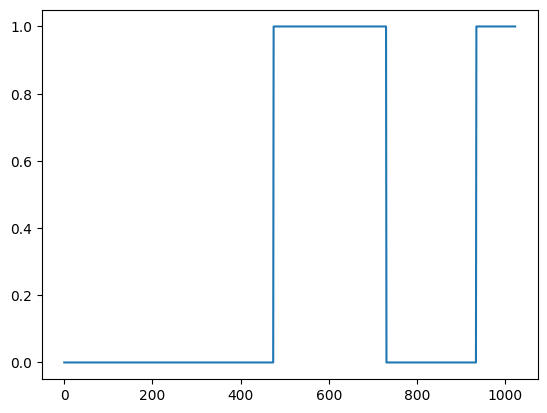

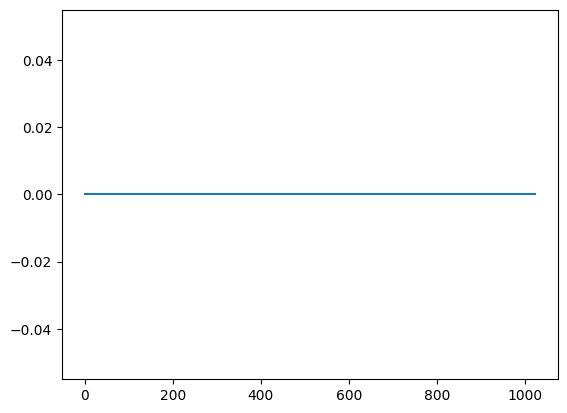

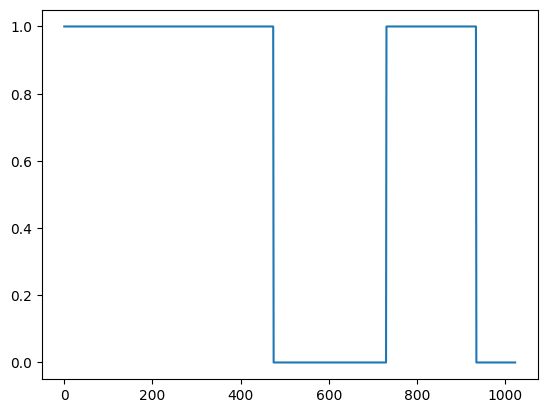

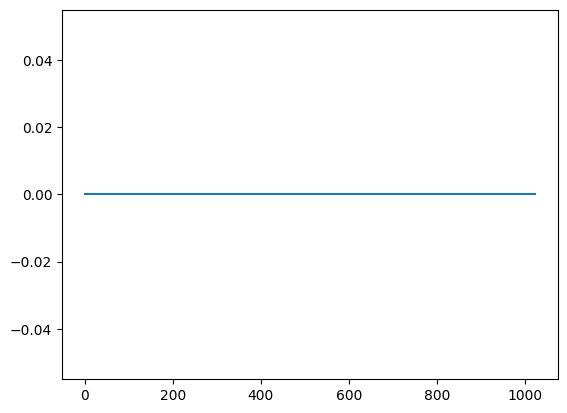

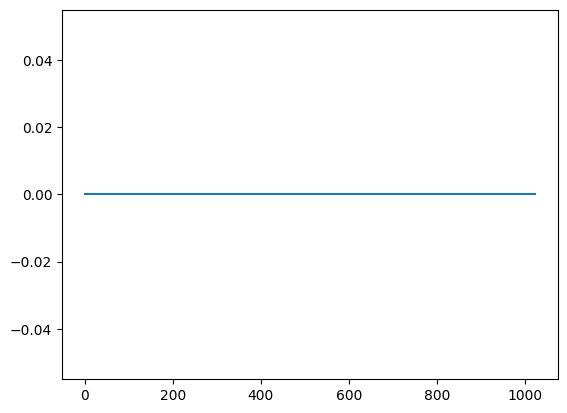

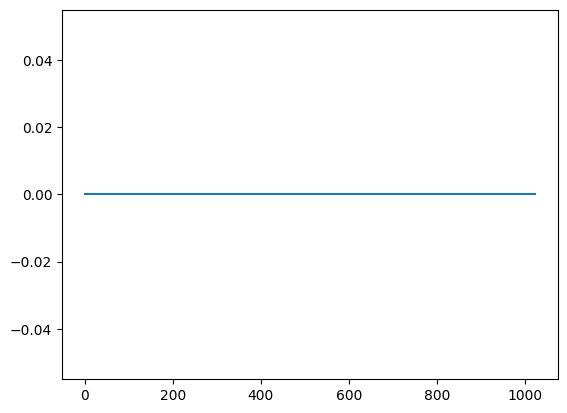

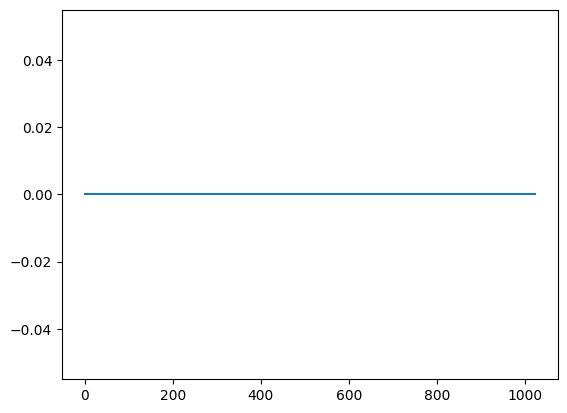

In [7]:
# Testing to see if the delta to head values are correct. They seem to be, maybe should
# do a custom test scenario


# print(player_deaths.iloc[7]["weapon"])

# plt.plot(context_window["attacker_pitch_head_delta"])
# plt.plot(context_window["attacker_yaw_head_delta"])
# plt.axvline(x=896)
# plt.show()

# plt.plot(context_window["attacker_kill"])
# plt.show()

plt.plot(context_window["attacker_weapon_knife"])
plt.show()

plt.plot(context_window["attacker_weapon_auto_rifle"])
plt.show()

plt.plot(context_window["attacker_weapon_semi_rifle"])
plt.show()

plt.plot(context_window["attacker_weapon_pistol"])
plt.show()

plt.plot(context_window["attacker_weapon_grenade"])
plt.show()

plt.plot(context_window["attacker_weapon_smg"])
plt.show()

plt.plot(context_window["attacker_weapon_shotgun"])
plt.show()

{'AK-47',
 'AUG',
 'AWP',
 'Bayonet',
 'Bowie Knife',
 'Butterfly Knife',
 'C4 Explosive',
 'CZ75-Auto',
 'Classic Knife',
 'Decoy Grenade',
 'Desert Eagle',
 'Dual Berettas',
 'FAMAS',
 'Falchion Knife',
 'Five-SeveN',
 'Flashbang',
 'Flip Knife',
 'G3SG1',
 'Galil AR',
 'Glock-18',
 'Gut Knife',
 'High Explosive Grenade',
 'Huntsman Knife',
 'Incendiary Grenade',
 'Karambit',
 'Kukri Knife',
 'M249',
 'M4A1-S',
 'M4A4',
 'M9 Bayonet',
 'MAC-10',
 'MAG-7',
 'MP5-SD',
 'MP7',
 'MP9',
 'Molotov',
 'Navaja Knife',
 'Negev',
 'Nomad Knife',
 None,
 'Nova',
 'P2000',
 'P250',
 'P90',
 'PP-Bizon',
 'Paracord Knife',
 'R8 Revolver',
 'SCAR-20',
 'SG 553',
 'SSG 08',
 'Sawed-Off',
 'Shadow Daggers',
 'Skeleton Knife',
 'Smoke Grenade',
 'Stiletto Knife',
 'Survival Knife',
 'Talon Knife',
 'Tec-9',
 'UMP-45',
 'USP-S',
 'Ursus Knife',
 'XM1014',
 'Zeus x27',
 'knife',
 'knife_t'}